## This code is mainly for:
## 1. Cleaning the data 
## 2. Properly separating(train/test) the data
## 3. Data normalization 
### by German Perea

## 1. Cleaning the data 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import datetime


### The raw data to clean are saved as 
### logs.csv
### amp_data.txt
### voltage_data.txt


In [2]:
# Read the data 

Logs = pd.read_csv('logs.csv')
amps = pd.read_csv('amp_data.txt', header=None)
volts = pd.read_csv('voltage_data.txt', header=None)


# Make a copy, to prevent changes in the original dataset 
amp = amps.copy()
volt = volts.copy()


In [3]:
# Column 0 represents Unix time for both amps and volts

unix = amp[0]

# This converts the Unix time into a Datetime format 
# The following Converts to 

x = pd.to_datetime(pd.Series(np.asarray(unix, dtype='datetime64[ms]')))


# Convert the time into United States Central time

central_time = x.dt.tz_localize("UTC").dt.tz_convert('US/Central')

amp['Date'] = central_time

# Sanity: check if the Values from Unix values from AMPS and Volts 
# are the same 

# Combine Amps and Volts together 

amp = amp.rename(columns = {1:'Ampere'})

# Some values in the amps are saved as 'None'
he = [str(i).replace(" ","") for i in volt[1]]


In [4]:
# Remove the values that are None  

volt1 = volt[[j!='None'for j in he]]
volt = np.array(volt1[1], dtype = float)


In [5]:
# Get rid of empty space

cl = [str(i).replace(" ","") for i in amp['Ampere']]

# Add the Voltage and Ampere columns

amp1 = amp[[k!='None' for k in cl]]

# Change the string values to float

amp1['Ampere'] = np.array(amp1['Ampere'], dtype = float)
amp1['Voltage'] = volt

amp1.head()



/Users/germa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/germa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


,0,Ampere,Date,Voltage
0,1554076800000,686.70,2019-03-31 19:00:00-05:00,593.0
1,1554077100000,684.08,2019-03-31 19:05:00-05:00,592.0
2,1554077400000,654.49,2019-03-31 19:10:00-05:00,593.6
3,1554077700000,670.80,2019-03-31 19:15:00-05:00,592.0
4,1554078000000,651.67,2019-03-31 19:20:00-05:00,592.3


In [6]:
amp_and_vol = amp1
amp_and_vol = amp_and_vol.drop(columns = [0])

# Make a copy of the original data 

modified_log = Logs.copy()
modified_log = modified_log.drop(columns = 'Unnamed: 0')


# ts: is in ts(timestime: in central time)
# Battery: positive values stand for charging 

modified_log['ts'] = pd.to_datetime(pd.Series(np.asarray(modified_log['ts'], dtype='datetime64[s]')))

# This is to match the correct 
# data format from Logs
# Change the date to an appropiate Date(without the small noise)
amp_and_vol['Date'] = pd.to_datetime(amp_and_vol['Date'].dt.strftime(('%B %d, %Y, %r')))

amp_and_vol.head()

,Ampere,Date,Voltage
0,686.70,2019-03-31 19:00:00,593.0
1,684.08,2019-03-31 19:05:00,592.0
2,654.49,2019-03-31 19:10:00,593.6
3,670.80,2019-03-31 19:15:00,592.0
4,651.67,2019-03-31 19:20:00,592.3


In [7]:
# Let's join the data based on the DataFrame where we know the State of Charge

# There are values where we don't have Amps and Voltage for the original data
# The original values with SOC is 40427, but not all SOC have AMPS and Volts
# We will drop these values: After dropping missing values, we have 34627 rows left 

modified = modified_log.join(amp_and_vol.set_index('Date'), on='ts').dropna().reset_index(drop=True)




In [8]:
## Rename 

X = modified 

# Rename columns 

X = X.rename(columns = {'Battery': 'Battery(kW)', 'building': 'Building(kW)', 'Adjusted Load': 'Adjusted Load (kW)'})


# Drop the rows in which the building has Negative Power

X = X[X['Building(kW)']>0]


### Nonlinear autoregressive exogenous (NARX) model 

Exogenous inputs (the model relates the current value of a time)

1. Past values of the same series 
2. Current and past values of the driving (exogenous) series — that is, of the externally determined series that influences the series of interest.


documentation on how to use NARX in Python:

https://firets.readthedocs.io/en/latest/models.html

parameters:

https://pypi.org/project/fireTS/


### In this case, we are using NARX in Matlab


#### Find the delta SOC 

deltaSOC 2 = SOC 2 - SOC 1

##### This means that the first row will be left with a None value.
##### We will replace the None value with the equivalent value of the 
##### second row. 



In [9]:
## Creating a column for the state of charge 

X['deltaSOC'] = X[['State of Charge']].diff(1, axis=0)['State of Charge']


Text(0.5, 1.0, 'deltaSOC for each row')

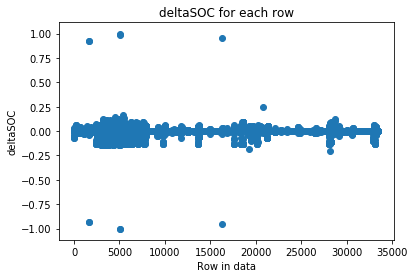

In [10]:
plt.scatter(np.arange(len(X)),X['deltaSOC'][0:len(X)])
plt.xlabel('Row in data')
plt.ylabel('deltaSOC')
plt.title('deltaSOC for each row')




Text(0.5, 1.0, 'Current')

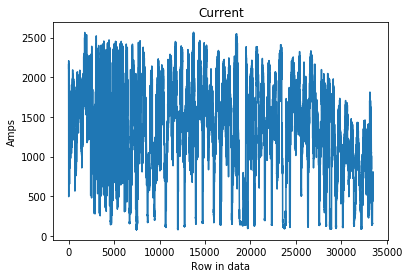

In [11]:
plt.plot(np.arange(len(X)),X['Ampere'][0:len(X)])
plt.ylabel('Amps')
plt.xlabel('Row in data')
plt.title('Current')




In [12]:
# Dropping the first row in data

X_new = X.copy()
X_new = X_new.iloc[1:]


## 2. Properly separating(train/test) the data


In [13]:
X['Year'] = X['ts'].dt.year
X['Week'] = X['ts'].dt.week
X['Hour'] = X['ts'].dt.hour
X['Day'] = X['ts'].dt.weekday


In [14]:
group = X.groupby(['Year','Week','Day']).count()


In [15]:
# We have 358 days worth of data 

#### This will capture true reprentation


In [16]:
# Need to know the neurons, loss function, activation, layers

## Replacing the first row with None value to the equivalent 
## of the second row!

X['deltaSOC'].iloc[0] = X['deltaSOC'].iloc[1]


/Users/germa/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [17]:
## Group by the Year and Week for training and 

gr = X[['Year','Week','Day']].groupby(['Year','Week']).size()


In [18]:
# Properly fixing the data

Z = X
CV = Z.groupby(['Year','Week','Day']).size().index.get_level_values(1).value_counts()
tu = pd.DataFrame(CV).rename(columns = {'Week':'values'})
X = X.join(tu, on = 'Week')



In [19]:
## By looking at the data, we have a week 22 for both 2019 and 2020 
## We can capture this and plug in the correct number of days in a week for each 
## of these two weeks 

bo = (X['Year']==2019) & (X['Week']==22)
nt = (X['Year']==2020) & (X['Week']==22)

## This hard coding the days of the week 
## Week 22 of 2019 has 2 days 
## Week 22 of 2020 has 7 days 
X.loc[bo, 'values'] = 2
X.loc[nt, 'values'] = 7



In [20]:
## Create a date column that has year-month-day

X['date'] = X['ts'].dt.strftime("%Y-%m-%d")
X.head()

,Battery(kW),State of Charge,Total Net Load (Sum of All Loads excluding Battery),ts,Building(kW),Adjusted Load (kW),Ampere,Voltage,deltaSOC,Year,Week,Hour,Day,values,date
0,-22.800101,0.572250,1975.492339,2019-06-01 04:15:00,1975.492339,1952.692237,2111.85,583.6,0.013387,2019,22,4,5,2,2019-06-01
1,139.599885,0.585636,1976.813313,2019-06-01 04:30:00,1976.813313,2116.413198,2167.47,582.3,0.013387,2019,22,4,5,2,2019-06-01
2,-7.200152,0.583871,1995.591711,2019-06-01 04:45:00,1995.591711,1988.391559,2029.17,583.4,-0.001765,2019,22,4,5,2,2019-06-01
3,-513.599510,0.527619,1945.208337,2019-06-01 05:00:00,1945.208337,1431.608827,1403.33,586.8,-0.056251,2019,22,5,5,2,2019-06-01
4,128.401671,0.542111,1978.229553,2019-06-01 05:15:00,1978.229553,2106.631224,2208.09,581.9,0.014492,2019,22,5,5,2,2019-06-01


In [21]:
## To avoid changing the initial error
## We can assign MN to be X

MN = X
bv = MN[['Week', 'values','date']].apply(tuple, axis=1)
MN['Triple'] = bv 

bv2 =  MN[['Week', 'values']].apply(tuple, axis = 1)
MN['Pairs'] = bv2


In [22]:
# This is important 
L = MN['Triple'].unique()

el = pd.DataFrame({'We':[x[0] for x in L], 'Va': [x[1] for x in L], 'Date': [x[2] for x in L]})

tr = pd.DataFrame(el.groupby(['We','Va']).apply(lambda x: list(x['Date'])))

zero = tr.index.get_level_values(0)
one = tr.index.get_level_values(1)

gt = pd.DataFrame({'X':zero, 'Y':one}).apply(tuple, axis=1)

gt.values



array([(1, 7), (2, 7), (3, 7), (4, 7), (5, 7), (6, 7), (7, 7), (8, 7),
       (9, 7), (10, 7), (11, 7), (12, 7), (13, 7), (14, 7), (15, 7),
       (16, 7), (17, 7), (18, 7), (19, 7), (20, 7), (21, 7), (22, 2),
       (22, 7), (23, 7), (24, 7), (25, 7), (26, 7), (27, 7), (28, 7),
       (29, 7), (30, 7), (31, 7), (32, 7), (33, 7), (34, 7), (35, 7),
       (36, 7), (37, 7), (38, 7), (39, 2), (40, 6), (41, 7), (42, 7),
       (43, 7), (44, 7), (45, 7), (46, 7), (47, 7), (48, 7), (49, 7),
       (50, 7), (51, 7), (52, 5)], dtype=object)

In [23]:
tr['Pairs'] = gt.values
tr = tr.reset_index(drop=True).rename(columns = {0: 'lstDates'})


In [24]:
# The following is how we are separating the data 

we = [x[0] for x in tr['Pairs']]
days = [x[1] for x in tr['Pairs']]


In [25]:
def trainSplit(dat):
    """Returns: dates that are suppose to go with
       train data"""
    np.random.seed(40)
    train = []
    we = [x[0] for x in dat['Pairs']] # the number of weeks
    days = [x[1] for x in dat['Pairs']] # the number of days
    ch = np.random.choice
    for i,j in zip(np.arange(len(we)), days):
        if j == 2:
            train.extend(ch(dat.iloc[i]['lstDates'], 1, replace = False))
            #Weeks with 2 days: extend 1 dates
       
        elif j == 5:
            train.extend(ch(dat.iloc[i]['lstDates'], 3, replace = False))
             #Weeks with 5 days: extend 3 dates
        
        elif j == 6:
            train.extend(ch(dat.iloc[i]['lstDates'], 3, replace = False))
            #Weeks with 6 days: extend 3 dates
        
        else:
            train.extend(ch(dat.iloc[i]['lstDates'], 5, replace = False))
            #Weeks with 7 days: extend 5 days
    return train

# Let's now apply the function into our dataset 

train_dates = trainSplit(tr)


In [26]:
# The following is the dataframe for training

training_data = MN[MN['date'].isin(train_dates)]

print("Percent on training data:",np.round(100*(len(training_data)/len(MN)),2), "%")

## Resetting the index
training_data = training_data.reset_index(drop=True)


Percent on training data: 70.66 %


In [27]:
# The following is for testing dataset
testing_data = MN[MN['date'].isin(train_dates)==False]


In [28]:
# input_nodes = 2
# hidden_nodes = 2
# output_nodes = 2


# output_order = 3
# incoming_weight_from_output = .6
# input_order = 2
# incoming_weight_from_input = .4

# net = neuralnetwork



In [29]:
## Dropping columns that was used to properly separate data but are no longer needed 
## to further do analysis in our data 

train_matlab = training_data.set_index('ts').drop(columns = ['values','date','Triple','Pairs','Year','Total Net Load (Sum of All Loads excluding Battery)'], axis = 1)

testing_matlab = testing_data.set_index('ts').drop(columns = ['values','Triple','Pairs','Year','Total Net Load (Sum of All Loads excluding Battery)','date'], axis = 1)

## Drop some columns from Dataset 

dataset = MN.drop(columns = ['values','ts','Triple','Pairs','Year','Total Net Load (Sum of All Loads excluding Battery)','date'], axis = 1)

# Use the whole dataset to normalize before splitting 


## 3. Data normalization
### including outliers

### Note: Week, Hour, and Day columns are also normalized
### Further recommendation is to use One-Hot-Encoding for these categorical values 



In [30]:
stats3 = dataset.describe()
stats3 = stats3.transpose()

def norm5(data):
    return (2*(data - stats3['min'])/(stats3['max']-stats3['min']) - 1)

train_normalized = norm5(train_matlab)
test_normalized = norm5(testing_matlab)
train_normalized.head()

## Uncomment for saving CSV files 

# train_normalized.to_csv('train_normalized')
# test_normalized.to_csv('test_normalized')


,Battery(kW),State of Charge,Building(kW),Adjusted Load (kW),Ampere,Voltage,deltaSOC,Week,Hour,Day
ts,,,,,,,,,,
2019-06-01 04:15:00,-0.005796,0.144499,0.696776,0.684906,0.634120,0.124519,0.013388,-0.176471,-0.652174,0.666667
2019-06-01 04:30:00,0.121377,0.171272,0.697911,0.813409,0.678746,0.091142,0.013388,-0.176471,-0.652174,0.666667
2019-06-01 04:45:00,0.006420,0.167741,0.714041,0.712926,0.567783,0.119384,-0.001765,-0.176471,-0.652174,0.666667
2019-06-01 05:00:00,-0.390134,0.055239,0.670763,0.275912,0.065651,0.206675,-0.056255,-0.176471,-0.565217,0.666667
2019-06-01 05:15:00,0.112608,0.084222,0.699128,0.805731,0.711337,0.080873,0.014493,-0.176471,-0.565217,0.666667


### Without outliers 
#### Outliers: considered to be delta SOC values that are above 0.5 and below -0.5 
#### There is a total (train + test sets) of 10 outliers 



In [31]:
#train_normalized.to_csv('training_normalized')

# Train set 
tr_outli = (train_normalized['deltaSOC']>0.5)|(train_normalized['deltaSOC']<-0.5)
train_normalized2 = train_normalized[~tr_outli]

# Testing set
te_outli = (test_normalized['deltaSOC']>0.5)|(test_normalized['deltaSOC']<-0.5)
test_normalized2 = test_normalized[~te_outli]

## Uncomment for saving CSV files 

# train_normalized2.to_csv('train_normalized2')
# test_normalized2.to_csv('test_normalized2')


Text(0.5, 1.0, 'Testing: deltaSOC')

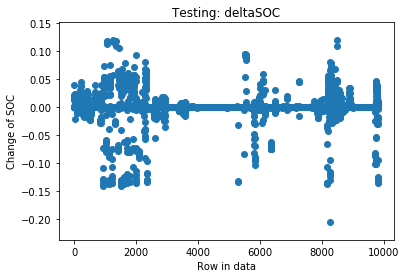

In [32]:
plt.scatter(np.arange(len(test_normalized2)),test_normalized2['deltaSOC'][0:len(test_normalized2)])
plt.ylabel('Change of SOC')
plt.xlabel('Row in data')
plt.title('Testing: deltaSOC')



Text(0.5, 1.0, 'Training: Battery power')

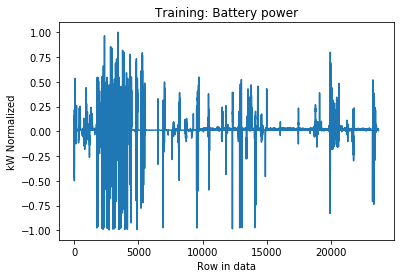

In [33]:
plt.plot(np.arange(len(train_normalized2)),train_normalized2['Battery(kW)'][0:len(train_normalized)])
plt.ylabel('kW Normalized')
plt.xlabel('Row in data')
plt.title('Training: Battery power')



Text(0.5, 1.0, 'Test: Battery power')

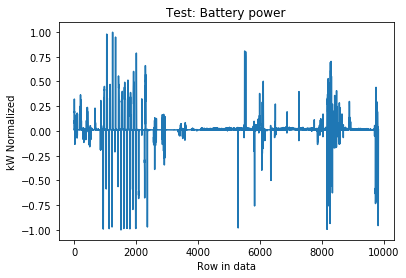

In [34]:
plt.plot(np.arange(len(test_normalized2)),test_normalized2['Battery(kW)'][0:len(test_normalized2)])
plt.ylabel('kW Normalized')
plt.xlabel('Row in data')
plt.title('Test: Battery power')